In [1]:
import numpy as np
import pandas as pd 
import copy
import os

import matplotlib.pyplot as plt
import seaborn as sns

from random import shuffle, randint

from numpy import mean, std, dstack

from pandas import read_csv

from keras import backend as K
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Model, Sequential
from keras.layers import (Input, Dense, Flatten, Dropout, Conv1D, LSTM, GRU,
                          TimeDistributed, GlobalAveragePooling1D, MaxPooling1D)
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.merge import concatenate

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

from keras.optimizers import Adam, RMSprop,SGD
from keras.utils import to_categorical
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

from scipy import signal

%matplotlib inline
with pd.option_context("display.max_rows", 10, "display.max_columns", 20):
    print(pd.get_option("display.max_rows")) 
    print(pd.get_option("display.max_columns"))
    
# Check GPU support 
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

np.set_printoptions(precision=4)
sns.set_palette("Set1", 8, .75)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None
%reload_ext autoreload
%autoreload 2

/home/jurgen/.local/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.
/home/jurgen/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jurgen/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jurgen/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a

10
20
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1538734159885563153
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12185704040752191681
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1115934844363606874
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3636068352
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1412119239357838237
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


change current directory for access to dataset and signal analysis core

In [2]:
from os import chdir as cd
cd('..')

### Import display graphics functions

In [3]:
from seriem_temporis.display_functions import display_block_of_values

# 1 Upload and preproccesing production dataset with synthetic anomalies

### 1.1 Read dataset

In [4]:
from seriem_temporis.controller import SignalController
signals = SignalController(filepath="datasets/L1_10-12.18.csv", 
                           rolling_window_size=1500, 
                           minimal_anomaly_length=50, 
                           sample_rate=40, 
                           encoding="cp1251", 
                           delimiter=",", 
                           corr_threshold=0.9, 
                           smooth_method='savgol', 
                           target_variable=None)

Number of columns: 96
Number of columns after corr analysis: 52
Number of columns after clean: 41
NaN Values: False
Successfully scaled control_results
savgol filter smoothing successful


### display non smooth dataset 

KeyboardInterrupt: 

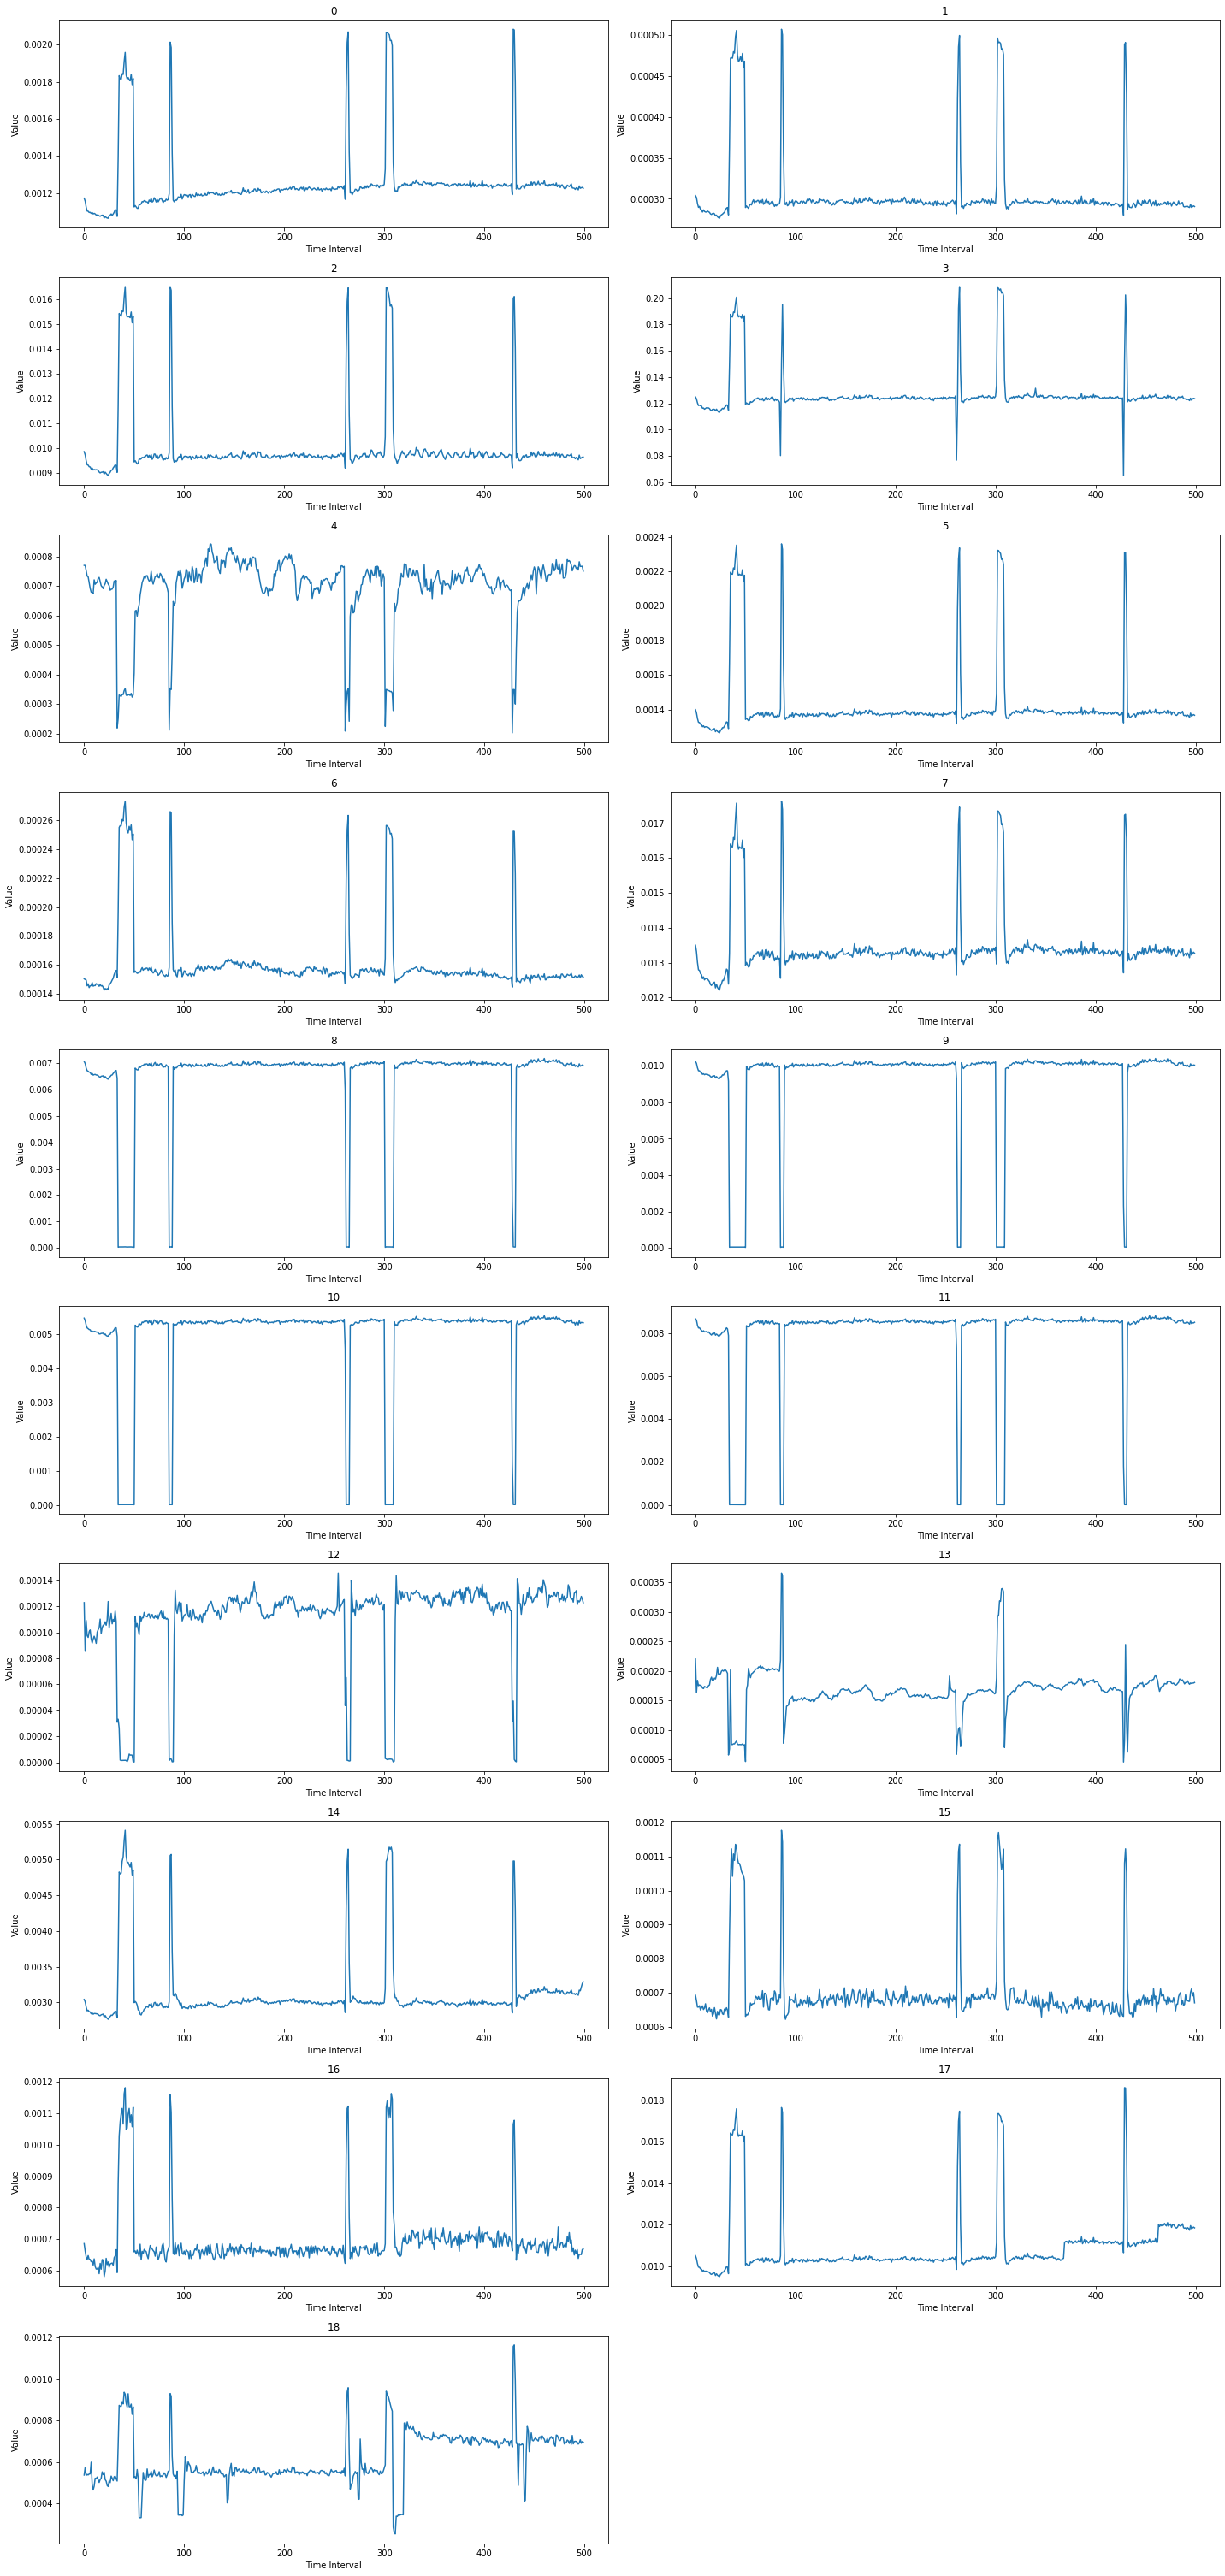

In [5]:
display_block_of_values(signals.scaled_control_results.iloc[:500],
              x_label='Time Interval',
              y_label='Value', 
              figsize=(20, 100),
              plot_size=(24,2))

### display savgol filter dataset 

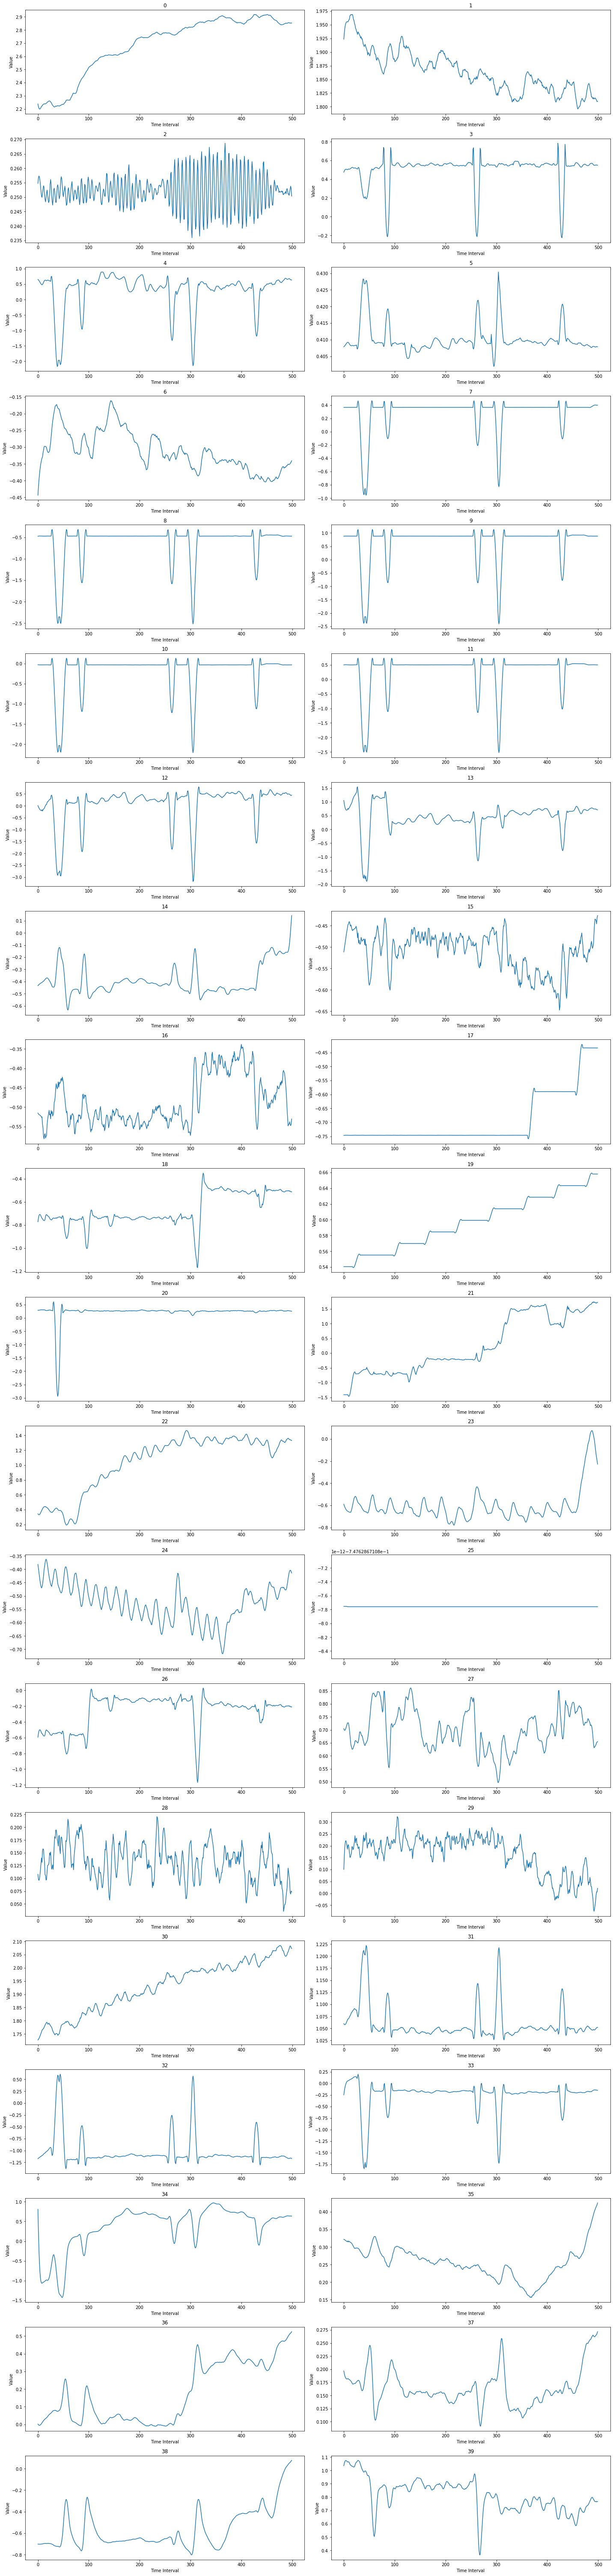

In [7]:
display_block_of_values(signals.smoothed_control_results.iloc[:500],
              x_label='Time Interval',
              y_label='Value', 
              figsize=(20, 100),
              plot_size=(24,2))

# Principal component analysis 2d and 3d

Объясненная вариация по основному компоненту: [0.91089798 0.032859   0.02019752]


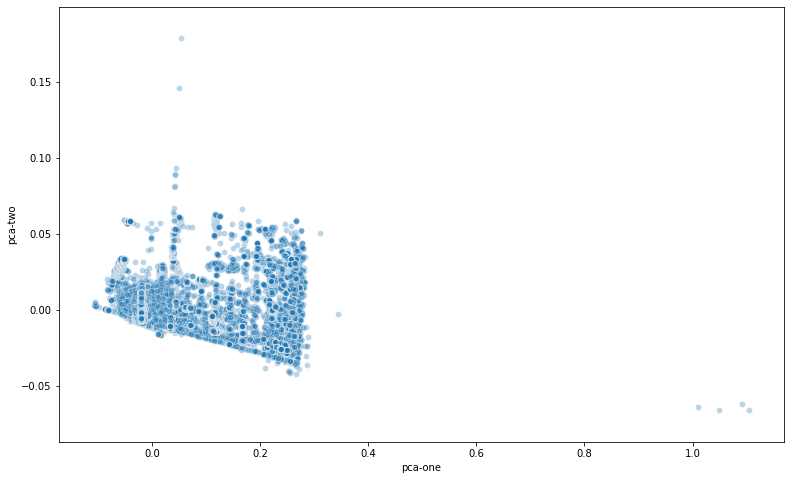

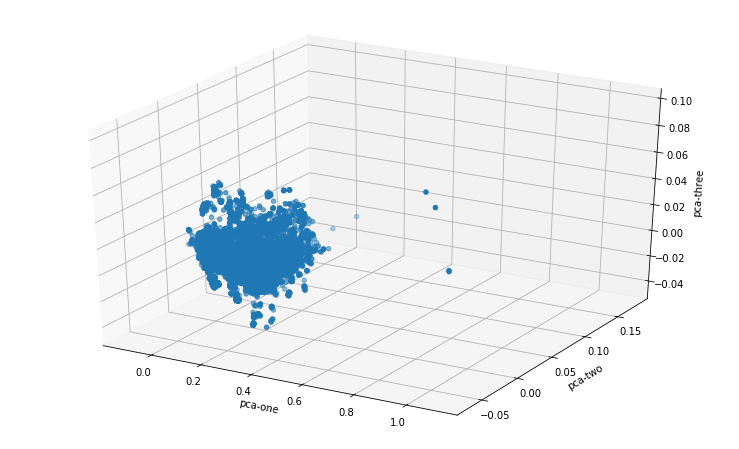

In [7]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(signals.scaled_control_results.values)

signals.scaled_control_results['pca-one'] = pca_result[:,0]
signals.scaled_control_results['pca-two'] = pca_result[:,1] 
signals.scaled_control_results['pca-three'] = pca_result[:,2]

print('Объясненная вариация по основному компоненту: {}'.format(pca.explained_variance_ratio_))


plt.figure(figsize=(13,8))
sns.scatterplot(
    x="pca-one", y="pca-two",
    palette=sns.color_palette("hls", 10),
    data=signals.scaled_control_results,
    legend="full",
    alpha=0.3
)

ax = plt.figure(figsize=(13,8)).gca(projection='3d')
ax.scatter(
    xs=signals.scaled_control_results["pca-one"], 
    ys=signals.scaled_control_results["pca-two"], 
    zs=signals.scaled_control_results["pca-three"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

# Anomaly generation 

In [5]:
type(signals.smoothed_control_results)

pandas.core.frame.DataFrame

In [6]:
signal_samples = signals.get_sliced_signal
signal_samples = signal_samples[:int(len(signals.get_sliced_signal)/2)]
anomaly_signal_samples = signals.generate_anomalies(signals.get_sliced_signal[int(len(signals.get_sliced_signal)/2):])

In [29]:
count = 0 
for sig in signal_samples:
    count += 1
    signal_target = pd.DataFrame(sig.values)
    signal_target['target'] = 0
    signal_target.to_csv(f'datasets/generated_anomalies/normal/normal_{count}.csv')
    
count = 0 
for sig in anomaly_signal_samples:
    count += 1
    signal_target = pd.DataFrame(sig.values)
    signal_target['target'] = sig.condition_window
    signal_target.to_csv(f'datasets/generated_anomalies/abnormal/abnormal_{count}.csv')


(500, 40)


KeyboardInterrupt: 

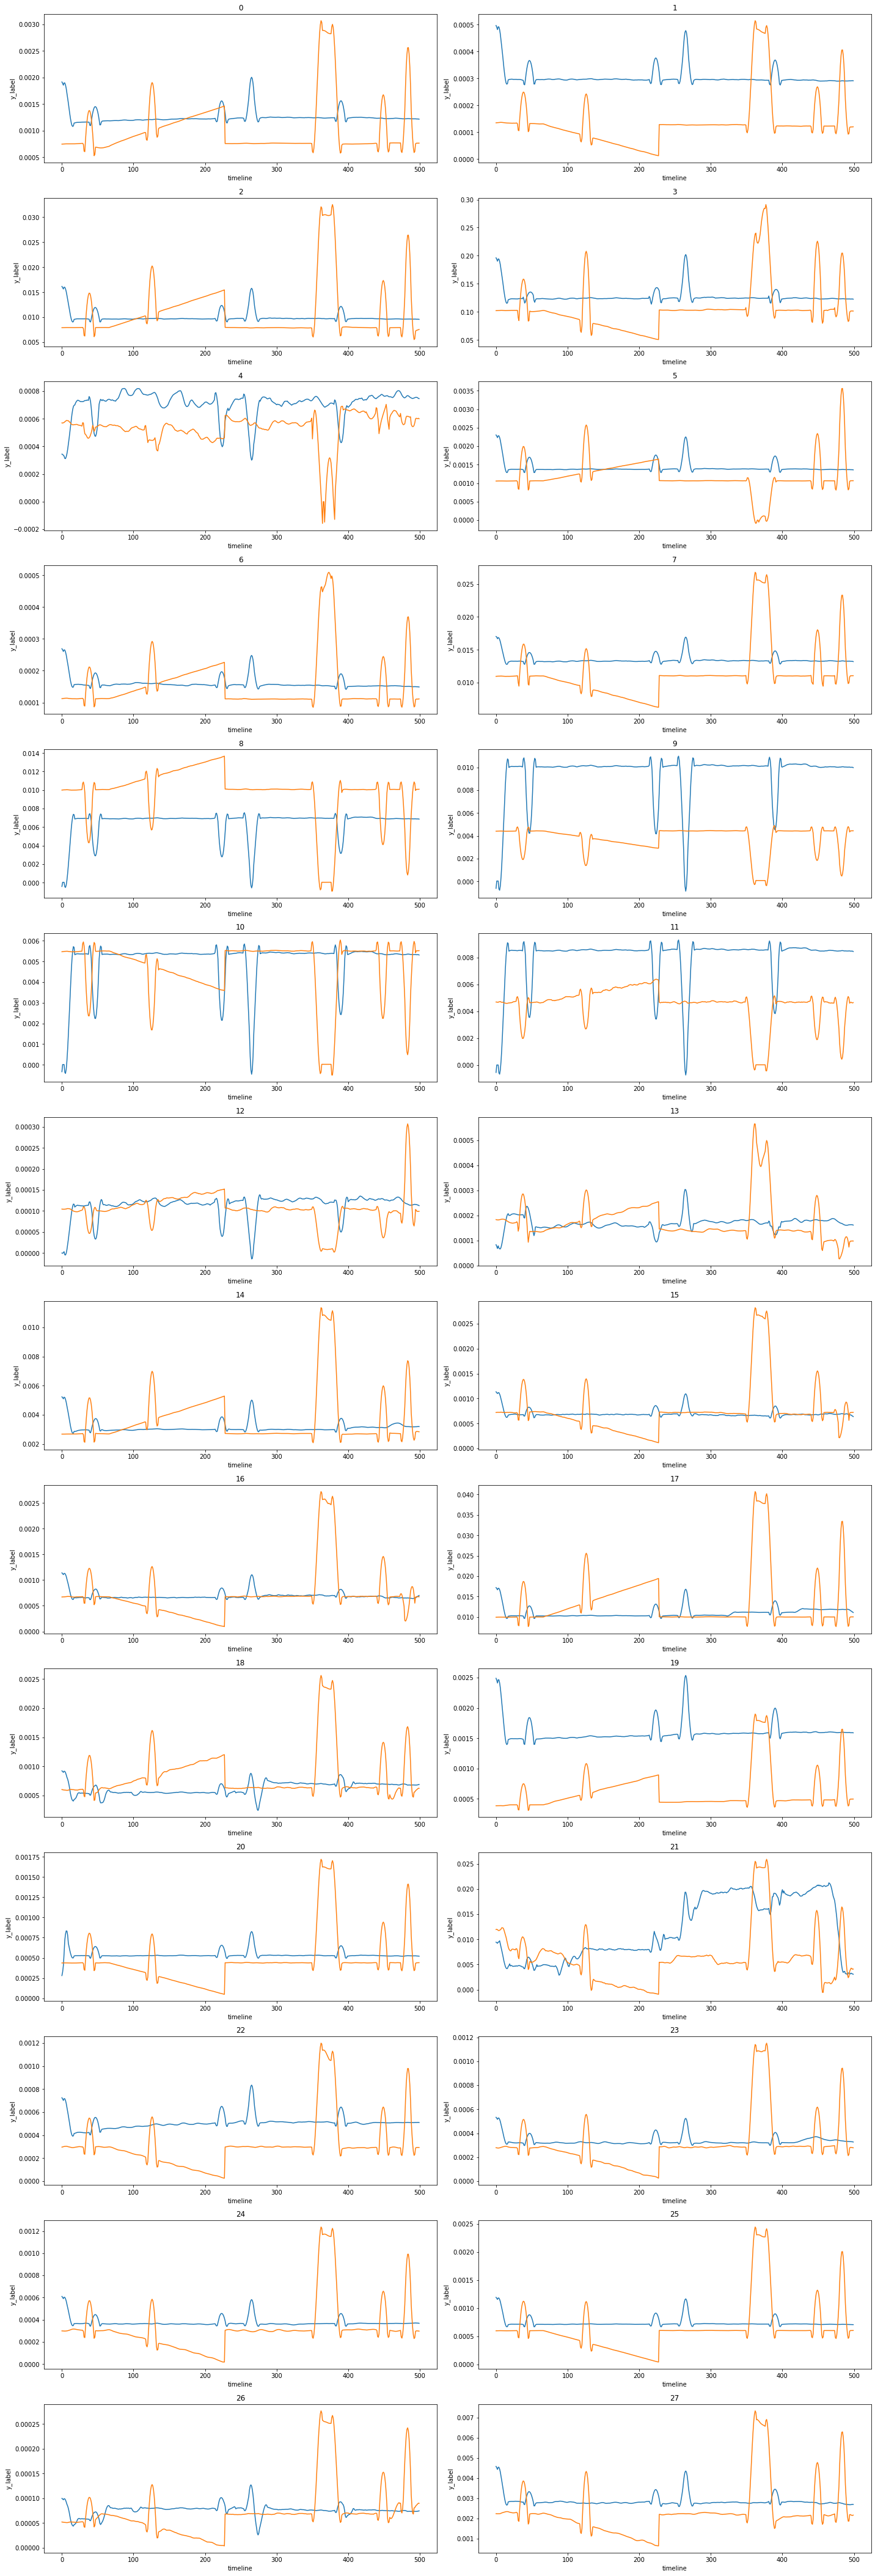

In [6]:
def display_signal_with_anomalies(samples , x_label='x_label', y_label='y_label',figsize=(15,30), plot_size=(15,3)):
    plt.figure(figsize=figsize)
    sample_number = 0
    print(samples.values.shape)
    for plot in range(plot_size[0]*plot_size[1]):
        plt.subplot(plot_size[0],plot_size[1], plot+1)
        plt.plot(signal_samples[1].values[:,plot])
        plt.plot(anomaly_signal_samples[1].values[: , plot])
        plt.title(plot)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.tight_layout()
        sample_number += 1

display_signal_with_anomalies(samples=anomaly_signal_samples[1],
                              x_label='timeline', 
                              y_label='y_label',
                              figsize=(20,100), 
                              plot_size=(24,2))

# Distributed Convolutional Neural Network with GRU output 

Concate anomaly signals and normal signals, and shufffle them for normal distribution

In [7]:
X_data = anomaly_signal_samples + signal_samples
shuffle(X_data)

Get train and test data sets in list of Signal classes format 

In [8]:
train_list, test_list = train_test_split(X_data, test_size=0.33, random_state=42)
print(len(train_list))
print(len(test_list))

2192
1081


Prepare education dataset

In [9]:
# Get data from Signal class into test list 
X_train = np.array([signal.values for signal in train_list])
Y_train = np.array([signal.condition_window for signal in train_list])

X_test = np.array([signal.values for signal in test_list])
Y_test = np.array([signal.condition_window for signal in test_list])

print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)


(2192, 1500, 40)
(2192, 1500)
(1081, 1500, 40)
(1081, 1500)


In [10]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 40))
Y_train = Y_train.reshape((Y_train.shape[0], Y_train.shape[1], 1))

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 40))
Y_test = Y_test.reshape((Y_test.shape[0],Y_test.shape[1], 1))


Convert dataset into correct format for neural network input 

In [11]:
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

(2192, 1500, 40)
(2192, 1500, 2)
(1081, 1500, 40)
(1081, 1500, 2)


Define metrics for controllable education

In [12]:
from sklearn.metrics import f1_score, precision_score, recall_score
def IOU_score():
    return

### Define neural network model 

![title](multichannel.png)

In [13]:
def evaluate_splitten_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 1,20,128
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # head 1
#     input_layer = Input(shape=(1024, 12))
    print(n_timesteps,n_features)
    inputs1 = Input(shape=(n_timesteps,n_features))
    conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
#     flat1 = Flatten()(pool1)
    flat1 = TimeDistributed(Flatten())(drop1)
    # head 2
    inputs2 = Input(shape=(n_timesteps,n_features))
    conv2 = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(inputs2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
#   flat2 = Flatten()(pool2)
    flat2 = TimeDistributed(Flatten())(drop2)
    # head 3
    inputs3 = Input(shape=(n_timesteps,n_features))
    conv3 = Conv1D(filters=64, kernel_size=11, activation='relu', padding='same')(inputs3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
#     flat3 = Flatten()(pool3)
    flat3 = TimeDistributed(Flatten())(drop3)

    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(100, activation='relu')(merged)
    
    outputs = GRU(2, activation="softmax", return_sequences=True)(dense1)
#     outputs = Dense(n_outputs, activation='softmax')(dense1)
    
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # save a plot of the model
    plot_model(model, show_shapes=True, to_file='multichannel.png')
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(loss="mse", optimizer="Adam",  metrics=['accuracy'])
    # fit network
    model.fit([trainX,trainX,trainX], trainy, epochs=epochs, batch_size=batch_size, verbose=1)
    # evaluate model
    _, accuracy = model.evaluate([testX,testX,testX], testy, batch_size=batch_size, verbose=1)
    return model, accuracy

# Fit and evaluate model 

In [14]:
# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))


# run an experiment
def run_splitten_experiment(repeats=1):
    scores = list()
    for r in range(repeats):
        model, score = evaluate_splitten_model(X_train, Y_train, X_test, Y_test)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)
    return model

# run the experiment
model_cont = run_splitten_experiment()

1500 40
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
2192/2192 [==============================] - 22s 10ms/step - loss: 0.1326 - accuracy: 0.8574
Epoch 2/20
2192/2192 [==============================] - 19s 9ms/step - loss: 0.1211 - accuracy: 0.8575
Epoch 3/20
2192/2192 [==============================] - 19s 9ms/step - loss: 0.1098 - accuracy: 0.8616
Epoch 4/20
2192/2192 [==============================] - 19s 9ms/step - loss: 0.0868 - accuracy: 0.8899
Epoch 5/20
2192/2192 [==============================] - 19s 9ms/step - loss: 0.0676 - accuracy: 0.9151
Epoch 6/20
2192/2192 [==============================] - 19s 9ms/step - loss: 0.0579 - accuracy: 0.9281
Epoch 7/20
2192/2192 [==============================] - 19s 9ms/step - loss: 0.0518 - accuracy: 0.9365
Epoch 8/20
2192/2192 [==============================] - 19s 9ms/step - loss: 0.0471 - accuracy: 0.9424
Epoch 9/20
2192/2192 [=========================

In [37]:
from seriem_temporis.display_functions import plot_model_history

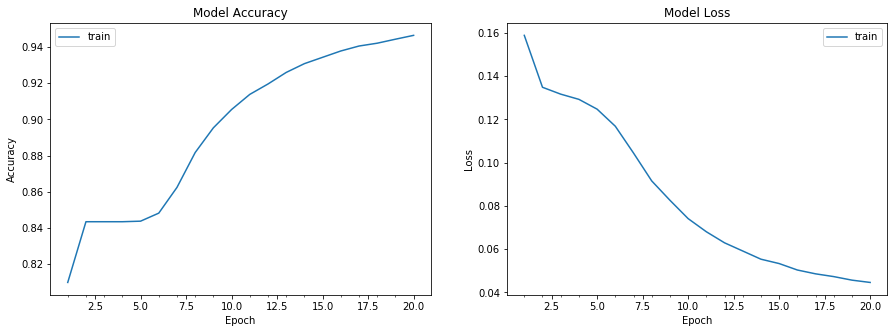

In [38]:
plot_model_history(model_cont.history)

Using neural result output for anomaly class 

In [48]:
y_pred = model_cont.predict([X_test,X_test,X_test])
y_anomaly_test = Y_test[:,:,1]
y_anomaly_prediction = y_pred[:,:,1]

In [40]:
decision_threshold = 0.8
y_anomaly_prediction = (y_anomaly_prediction > decision_threshold).astype(float)

In [41]:
print(y_anomaly_prediction.shape)
print(y_anomaly_test.shape)

(1085, 1000)
(1085, 1000)


### The implementation of the result will be carried out through a cumulative assessment of the output of the neural network.

In [42]:
cummulative_test = y_anomaly_test.reshape(y_anomaly_test.shape[0]*y_anomaly_test.shape[1])
cummulative_test_pred = y_anomaly_prediction.reshape(y_anomaly_test.shape[0]*y_anomaly_test.shape[1])

In [43]:
print(cummulative_test.shape)
print(cummulative_test_pred.shape)

(1085000,)
(1085000,)


In [44]:
_f1_score = f1_score(cummulative_test, cummulative_test_pred)
_recall_score = recall_score(cummulative_test, cummulative_test_pred)
_precision_score = precision_score(cummulative_test, cummulative_test_pred)

In [45]:
print(_f1_score, _recall_score, _precision_score)

0.7473924194927329 0.6051327607192095 0.9770963926119799


Calculate IOU for results

In [46]:
IOU = []
for idx, i in enumerate(y_anomaly_prediction):
    OL = 0
    UN = 0
    for _idx, result in enumerate(i):
        if result ==1 and y_anomaly_test[idx,_idx]==1:
            OL += 1  
        if result ==1 or y_anomaly_test[idx,_idx]==1:
            UN += 1
    if OL != 0 and UN != 0:
        IOU.append(OL/UN)

In [47]:
print(mean(IOU))

0.5897596194381199


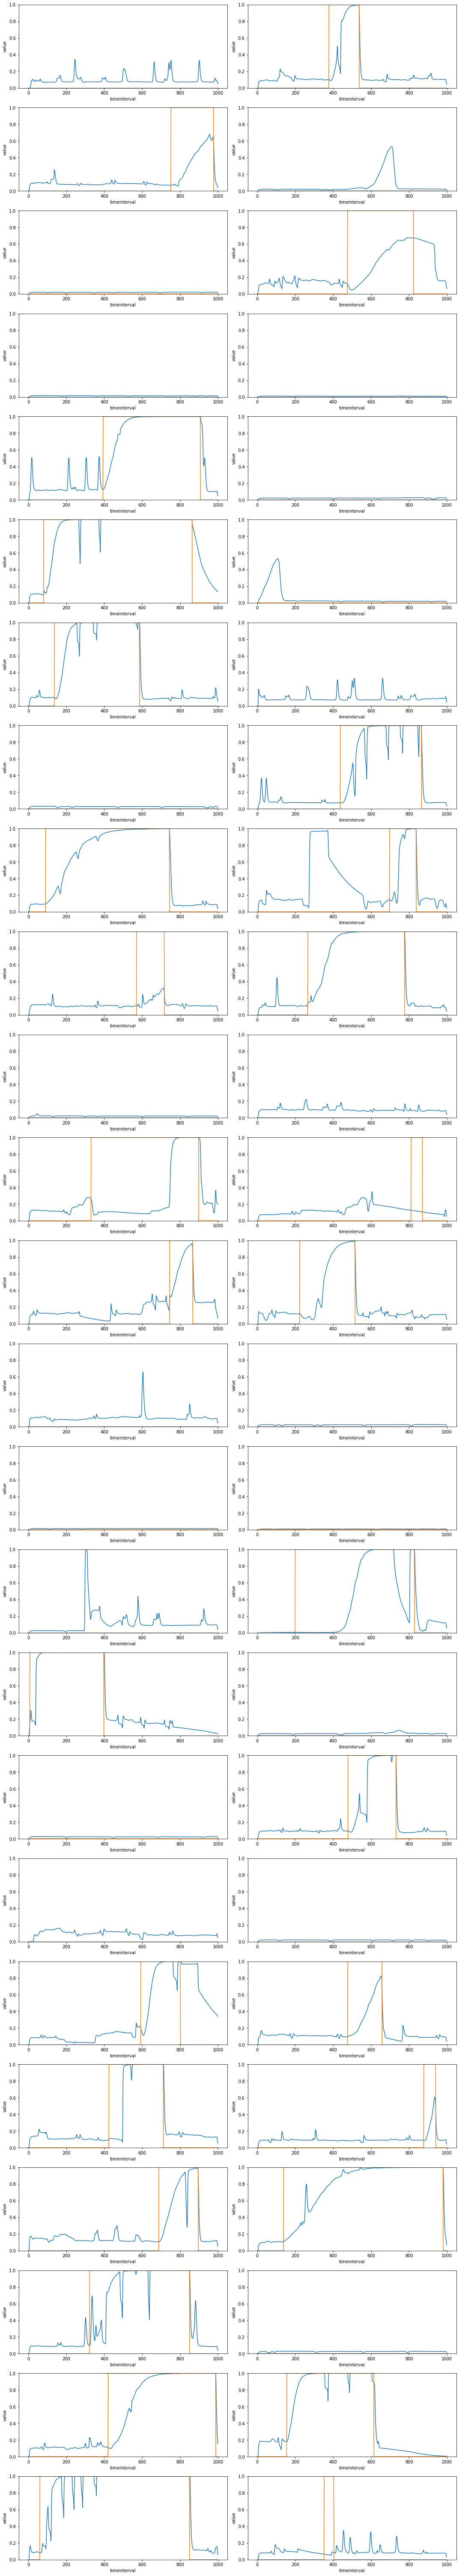

In [49]:
plt.figure(figsize=(15,100))
for index, sample in enumerate(Y_test[:50]):
    plt.subplot(30, 2, index+1)
    plt.ylim(0, 1)
    plt.plot(y_anomaly_prediction[index])
    plt.plot(y_anomaly_test[index])
    plt.xlabel('timeinterval')
    plt.ylabel('value')
    plt.tight_layout()

# Conclusion

In [16]:
signals.control_results.info()
# type(signals.control_results['BT28500'])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132398 entries, 2018-10-01 00:00:00 to 2018-12-31 23:58:00
Data columns (total 40 columns):
BT28500        132398 non-null float64
BT31200        132398 non-null float64
T22412         132398 non-null float64
F22410         132398 non-null float64
M10I           132398 non-null float64
M10pr          132398 non-null float64
BT33001        132398 non-null float64
M73000rpm      132398 non-null float64
NL             132398 non-null float64
NR             132398 non-null float64
Val1           132398 non-null float64
Val3           132398 non-null float64
Perfomance     132398 non-null float64
Speed          132398 non-null float64
BT22502        132398 non-null float64
M18500         132398 non-null float64
M19000         132398 non-null float64
M22600         132398 non-null float64
Plotnost       132398 non-null float64
TimeWork       132398 non-null int64
M75000A        132398 non-null float64
Recycling      132398 non-null float64

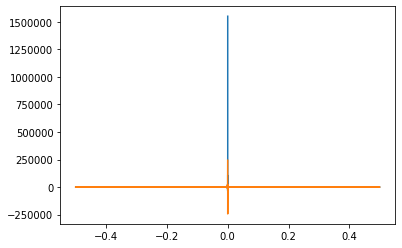

In [21]:
import matplotlib.pyplot as plt


test_fft = signals.control_results['BT31200'].to_numpy()


sp = np.fft.fft(test_fft)

freq = np.fft.fftfreq(test_fft.shape[-1])
plt.plot(freq, sp.real, freq, sp.imag)

plt.show()


In [5]:
signals.scaled_control_results.describe()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
count,132398.000000,132398.000000,132398.000000,132398.000000,132398.000000,132398.000000,132398.000000,132398.000000,132398.000000,132398.000000,...,132398.000000,132398.000000,132398.000000,132398.000000,132398.000000,132398.000000,132398.000000,132398.000000,132398.000000,132398.000000
mean,0.000918,0.000204,0.009825,0.118208,0.000578,0.001206,0.000196,0.012387,0.007721,0.006489,...,0.000196,-0.004941,-0.002210,0.991144,0.000630,0.000765,0.000827,0.000936,0.000946,0.000561
std,0.000469,0.000130,0.005344,0.048754,0.000189,0.000616,0.000169,0.004003,0.003285,0.003294,...,0.000132,0.003346,0.000781,0.013433,0.000259,0.000372,0.000464,0.000710,0.000514,0.000271
min,0.000000,0.000000,-0.000667,0.010567,0.000000,0.000000,0.000000,0.000000,0.000011,0.000021,...,0.000000,-0.029613,-0.023710,-0.630001,-0.001650,0.000261,-0.000927,0.000282,0.000280,0.000187
25%,0.000707,0.000126,0.008081,0.100780,0.000562,0.001108,0.000119,0.011041,0.006972,0.004822,...,0.000115,-0.007693,-0.002548,0.993253,0.000518,0.000613,0.000651,0.000720,0.000746,0.000440
50%,0.000766,0.000154,0.008494,0.105252,0.000620,0.001163,0.000158,0.011538,0.008435,0.006434,...,0.000158,-0.006814,-0.002125,0.994017,0.000616,0.000661,0.000736,0.000778,0.000831,0.000486
75%,0.000834,0.000234,0.008994,0.112822,0.000669,0.001239,0.000199,0.012261,0.010033,0.009184,...,0.000216,-0.001139,-0.001788,0.994536,0.000706,0.000749,0.000827,0.000867,0.000922,0.000551
max,0.007173,0.002018,0.085200,0.983700,0.002569,0.012042,0.002611,0.091070,0.046883,0.042861,...,0.001905,0.000001,0.000417,0.999814,0.004669,0.006795,0.022439,0.029236,0.031027,0.005310


In [ ]:
signals